In [1]:
!nvidia-smi -h

NVIDIA System Management Interface -- v555.85

NVSMI provides monitoring information for Tesla and select Quadro devices.
The data is presented in either a plain text or an XML format, via stdout or a file.
NVSMI also provides several management operations for changing the device state.

Note that the functionality of NVSMI is exposed through the NVML C-based
library. See the NVIDIA developer website for more information about NVML.
Python wrappers to NVML are also available.  The output of NVSMI is
not guaranteed to be backwards compatible; NVML and the bindings are backwards
compatible.

http://developer.nvidia.com/nvidia-management-library-nvml/
http://pypi.python.org/pypi/nvidia-ml-py/
Supported products:
- Full Support
    - All Tesla products, starting with the Kepler architecture
    - All Quadro products, starting with the Kepler architecture
    - All GRID products, starting with the Kepler architecture
    - GeForce Titan products, starting with the Kepler architecture
- Limi

In [2]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import cv2
import zipfile
import shutil
import random
import pandas as pd
import csv
import os

In [3]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth for each GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f'{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs')
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU available.")
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

No GPU available.
Num GPUs Available:  0


In [4]:
data_path="/Users/deepa/Downloads/archive (2)/"

In [5]:
max_images_per_class = 1000
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
def collect_data(folder):
    data = []
    for clas in classes:
        class_path = os.path.join(data_path, folder, clas)
        files = [os.path.join(folder, clas, file) for file in os.listdir(class_path) if file.endswith('.jpg')]
        if len(files) > max_images_per_class:
            files = random.sample(files, max_images_per_class)
        data.extend([[file, clas] for file in files])
    return data
max_images_per_class_1 = 100
def collect_data_1(folder):
    data = []
    for clas in classes:
        class_path = os.path.join(data_path, folder, clas)
        files = [os.path.join(folder, clas, file) for file in os.listdir(class_path) if file.endswith('.jpg')]
        if len(files) > max_images_per_class_1:
            files = random.sample(files, max_images_per_class_1)
        data.extend([[file, clas] for file in files])
    return data
# Collect train and test data
train_data = collect_data('seg_train/seg_train')
test_data = collect_data_1('seg_test/seg_test')

In [6]:
# Write train and test CSV files
os.makedirs('data', exist_ok=True)
with open('data/train.csv', 'w', newline='') as f:
    csvw = csv.writer(f)
    csvw.writerow(['filename', 'class'])
    for item in train_data:
        csvw.writerow(item)

with open('data/test.csv', 'w', newline='') as f:
    csvw = csv.writer(f)
    csvw.writerow(['filename', 'class'])
    for item in test_data:
        csvw.writerow(item)

# Load data into dataframes
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")


In [7]:
# Debugging: Print the first few rows of the dataframes
print("Train DataFrame Head:\n", train_df.head())
print("Test DataFrame Head:\n", test_df.head())


Train DataFrame Head:
                                   filename      class
0  seg_train/seg_train\buildings\18694.jpg  buildings
1  seg_train/seg_train\buildings\13946.jpg  buildings
2   seg_train/seg_train\buildings\1647.jpg  buildings
3  seg_train/seg_train\buildings\19526.jpg  buildings
4  seg_train/seg_train\buildings\12417.jpg  buildings
Test DataFrame Head:
                                 filename      class
0  seg_test/seg_test\buildings\20629.jpg  buildings
1  seg_test/seg_test\buildings\20083.jpg  buildings
2  seg_test/seg_test\buildings\23815.jpg  buildings
3  seg_test/seg_test\buildings\23388.jpg  buildings
4  seg_test/seg_test\buildings\22642.jpg  buildings


In [8]:
# Set data augmentation techniques
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    rotation_range=360,
    width_shift_range=0.1,
    height_shift_range=0.1,
    channel_shift_range=50,
    brightness_range=(0, 1.2),
    preprocessing_function=keras.applications.imagenet_utils.preprocess_input
)

test_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.imagenet_utils.preprocess_input
)

In [9]:
# Create data generators
batch_size = 70
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=data_path,
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=data_path,
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

train_img_num = len(train_generator.filenames)


Found 6000 validated image filenames belonging to 6 classes.
Found 600 validated image filenames belonging to 6 classes.


In [10]:
name = "Intel-DenseNet169-depthw-constraints-224"
os.makedirs("models", exist_ok=True)  # Create folder for saving checkpoints
os.makedirs("reports", exist_ok=True)  # Create folder for saving evaluation reports

keras.backend.clear_session()  # Clear backend

shape = (224, 224, 3)
input_tensor = keras.Input(shape=shape)
base_model = keras.applications.DenseNet169(input_tensor=input_tensor, weights=None, include_top=False)

depth = keras.layers.DepthwiseConv2D(
    tuple(base_model.output.shape[1:3]),
    depthwise_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
    bias_initializer=keras.initializers.Zeros(),
    depthwise_constraint=keras.constraints.NonNeg()
)(base_model.output)

flat = keras.layers.Flatten()(depth)
preds = keras.layers.Dense(
    6,
    activation='softmax',
    kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
    bias_initializer=keras.initializers.Zeros()
)(flat)

model = keras.Model(inputs=base_model.input, outputs=preds)

for layer in model.layers:
    layer.trainable = True

model.summary()

# ModelCheckpoint
filepath = "models/{}-{{epoch:02d}}-{{val_accuracy:.4f}}.keras".format(name)
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=False, mode='max')  # Create checkpoint to save the best validation accuracy
callbacks_list = [checkpoint]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 56, 56, 64)        │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 56, 56, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 56, 56, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 12,736,070 (48.58 MB)

 Trainable params: 12,577,670 (47.98 MB)

 Non-trainable params: 158,400 (618.75 KB)

In [12]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.045,
    decay_steps=2 * int(train_img_num / batch_size),
    decay_rate=0.94,
    staircase=True
)
optimizer = keras.optimizers.SGD(momentum=0.9, learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Start training
hist = model.fit(
    train_generator,
    epochs=80,
    validation_data=validation_generator,
    shuffle=True,
    callbacks=callbacks_list
)


Epoch 1/80


C:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


86/86 ━━━━━━━━━━━━━━━━━━━━ 1934s 22s/step - accuracy: 0.2794 - loss: 1.6610 - val_accuracy: 0.1983 - val_loss: 2.9156
Epoch 2/80
86/86 ━━━━━━━━━━━━━━━━━━━━ 1666s 19s/step - accuracy: 0.4115 - loss: 1.3972 - val_accuracy: 0.3300 - val_loss: 1.9153
Epoch 3/80
86/86 ━━━━━━━━━━━━━━━━━━━━ 1554s 18s/step - accuracy: 0.4433 - loss: 1.3385 - val_accuracy: 0.4333 - val_loss: 1.4052
Epoch 4/80
86/86 ━━━━━━━━━━━━━━━━━━━━ 1503s 17s/step - accuracy: 0.4938 - loss: 1.2602 - val_accuracy: 0.4367 - val_loss: 1.3465
Epoch 5/80
86/86 ━━━━━━━━━━━━━━━━━━━━ 1510s 18s/step - accuracy: 0.4941 - loss: 1.2443 - val_accuracy: 0.5050 - val_loss: 1.1887
Epoch 6/80
86/86 ━━━━━━━━━━━━━━━━━━━━ 1507s 17s/step - accuracy: 0.5311 - loss: 1.2020 - val_accuracy: 0.5133 - val_loss: 1.2042
Epoch 7/80
86/86 ━━━━━━━━━━━━━━━━━━━━ 1508s 17s/step - accuracy: 0.5283 - loss: 1.1928 - val_accuracy: 0.4717 - val_loss: 1.2977
Epoch 8/80
86/86 ━━━━━━━━━━━━━━━━━━━━ 1505s 17s/step - accuracy: 0.5274 - loss: 1.1636 - val_accuracy: 0.550

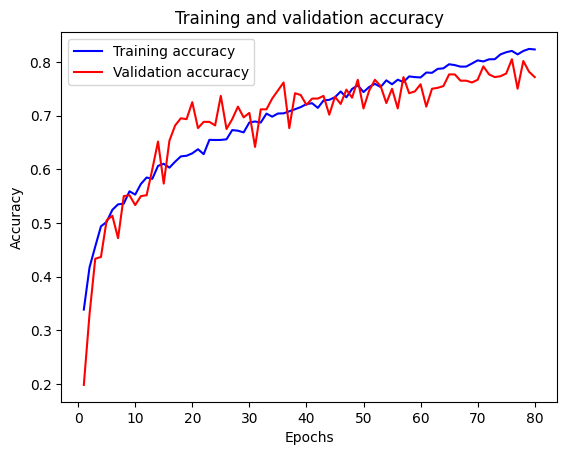

In [21]:
# Get the accuracy and validation accuracy from the history
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

# Get the number of epochs
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

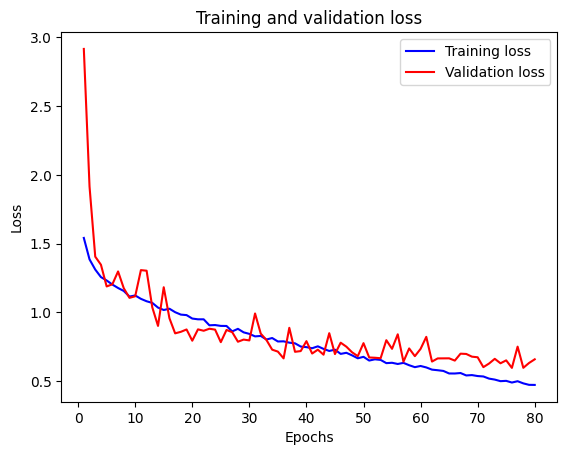

In [22]:

import matplotlib.pyplot as plt# Get the accuracy and validation loss from the history
acc = hist.history['loss']
val_acc = hist.history['val_loss']

# Get the number of epochs
epochs = range(1, len(acc) + 1)

# Plot training and validation loss
plt.plot(epochs, acc, 'b', label='Training loss')
plt.plot(epochs, val_acc, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()